<a href="https://colab.research.google.com/github/painterV/runlearning/blob/main/%E9%98%AE%E5%81%A5%E4%BB%AA%E8%AF%95%E8%AF%BE%E8%AE%BE%E8%AE%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 案例需求

    我现在做的一个项目是这样的，我是分析B站上一个视频，它上面的一个评论，然后可能是对这个评论的数据进行采集，然后，还要进行一定的清洗，并且进行一个词频统计，还有情感分析。

## 本案例所需技术点

### Python的语法

- 数据类型
- 控制语句
- 函数与模块
- IO（文件读写）
- 库调用(学会API调用，走遍天下都不怕)

### 初级

- 爬虫技术：
    - 学会使用Python请求网络数据
    - 学会分析网页的数据
- 数据分析（数据统计与挖掘）
    - pandas库的学习使用
- 分词
    - jieba分词库的学习使用
- 情感分析（机器学习）
    - 利用现有的情感分析库
    - 利用一些比较效果好的模型
- 数据库(高阶一点)
    - python操作各类数据库


上面提及的只是众多解决方案的一种。


下面我们来简单看一下本案例的方案的部分实现。

## 什么是爬虫？

首先我们要了解什么是爬虫。

爬虫技术的核心原理是模拟浏览器行为，通过发送HTTP请求获取网页数据，并解析提取所需的信息。

下面是爬虫技术的核心原理的概述：

- 发送HTTP请求：爬虫首先根据目标网页的URL构建合适的HTTP请求，通常使用GET请求来获取网页内容。请求可以包含一些头部信息，如User-Agent、Cookie等，以模拟浏览器的行为。

- 接收响应：当发送请求后，爬虫会等待服务器的响应，并接收返回的HTTP响应。响应中包含了服务器返回的网页内容，以及其他有用的信息，如状态码、头部信息等。

- 解析网页：爬虫通过解析网页内容，可以提取出所需的信息。通常使用HTML解析库（如BeautifulSoup）或正则表达式来解析网页结构，并提取出需要的数据，如文本、链接、图片等。

- 处理数据：获取到所需的数据后，爬虫可以对数据进行处理、清洗和转换，以满足具体的需求。例如，可以进行数据清洗、格式转换、去重等操作。

- 存储数据：爬虫可以将获取到的数据存储到适当的存储介质中，如文件、数据库等。存储数据可以用于后续的分析、展示或其他用途。

需要注意的是，爬虫技术在实际应用中需要遵守法律和网站的规定，尊重网站的访问频率限制和robots.txt协议，避免对目标网站造成过大的负荷和干扰。此外，爬虫应该注意隐私保护和数据安全，避免非法获取和滥用他人的信息。

**总结而言，爬虫技术的核心原理是发送HTTP请求、接收响应、解析网页和处理数据，以获取所需的信息。**


如果要讲深一点，可能要涉及到网页是怎么形成的。

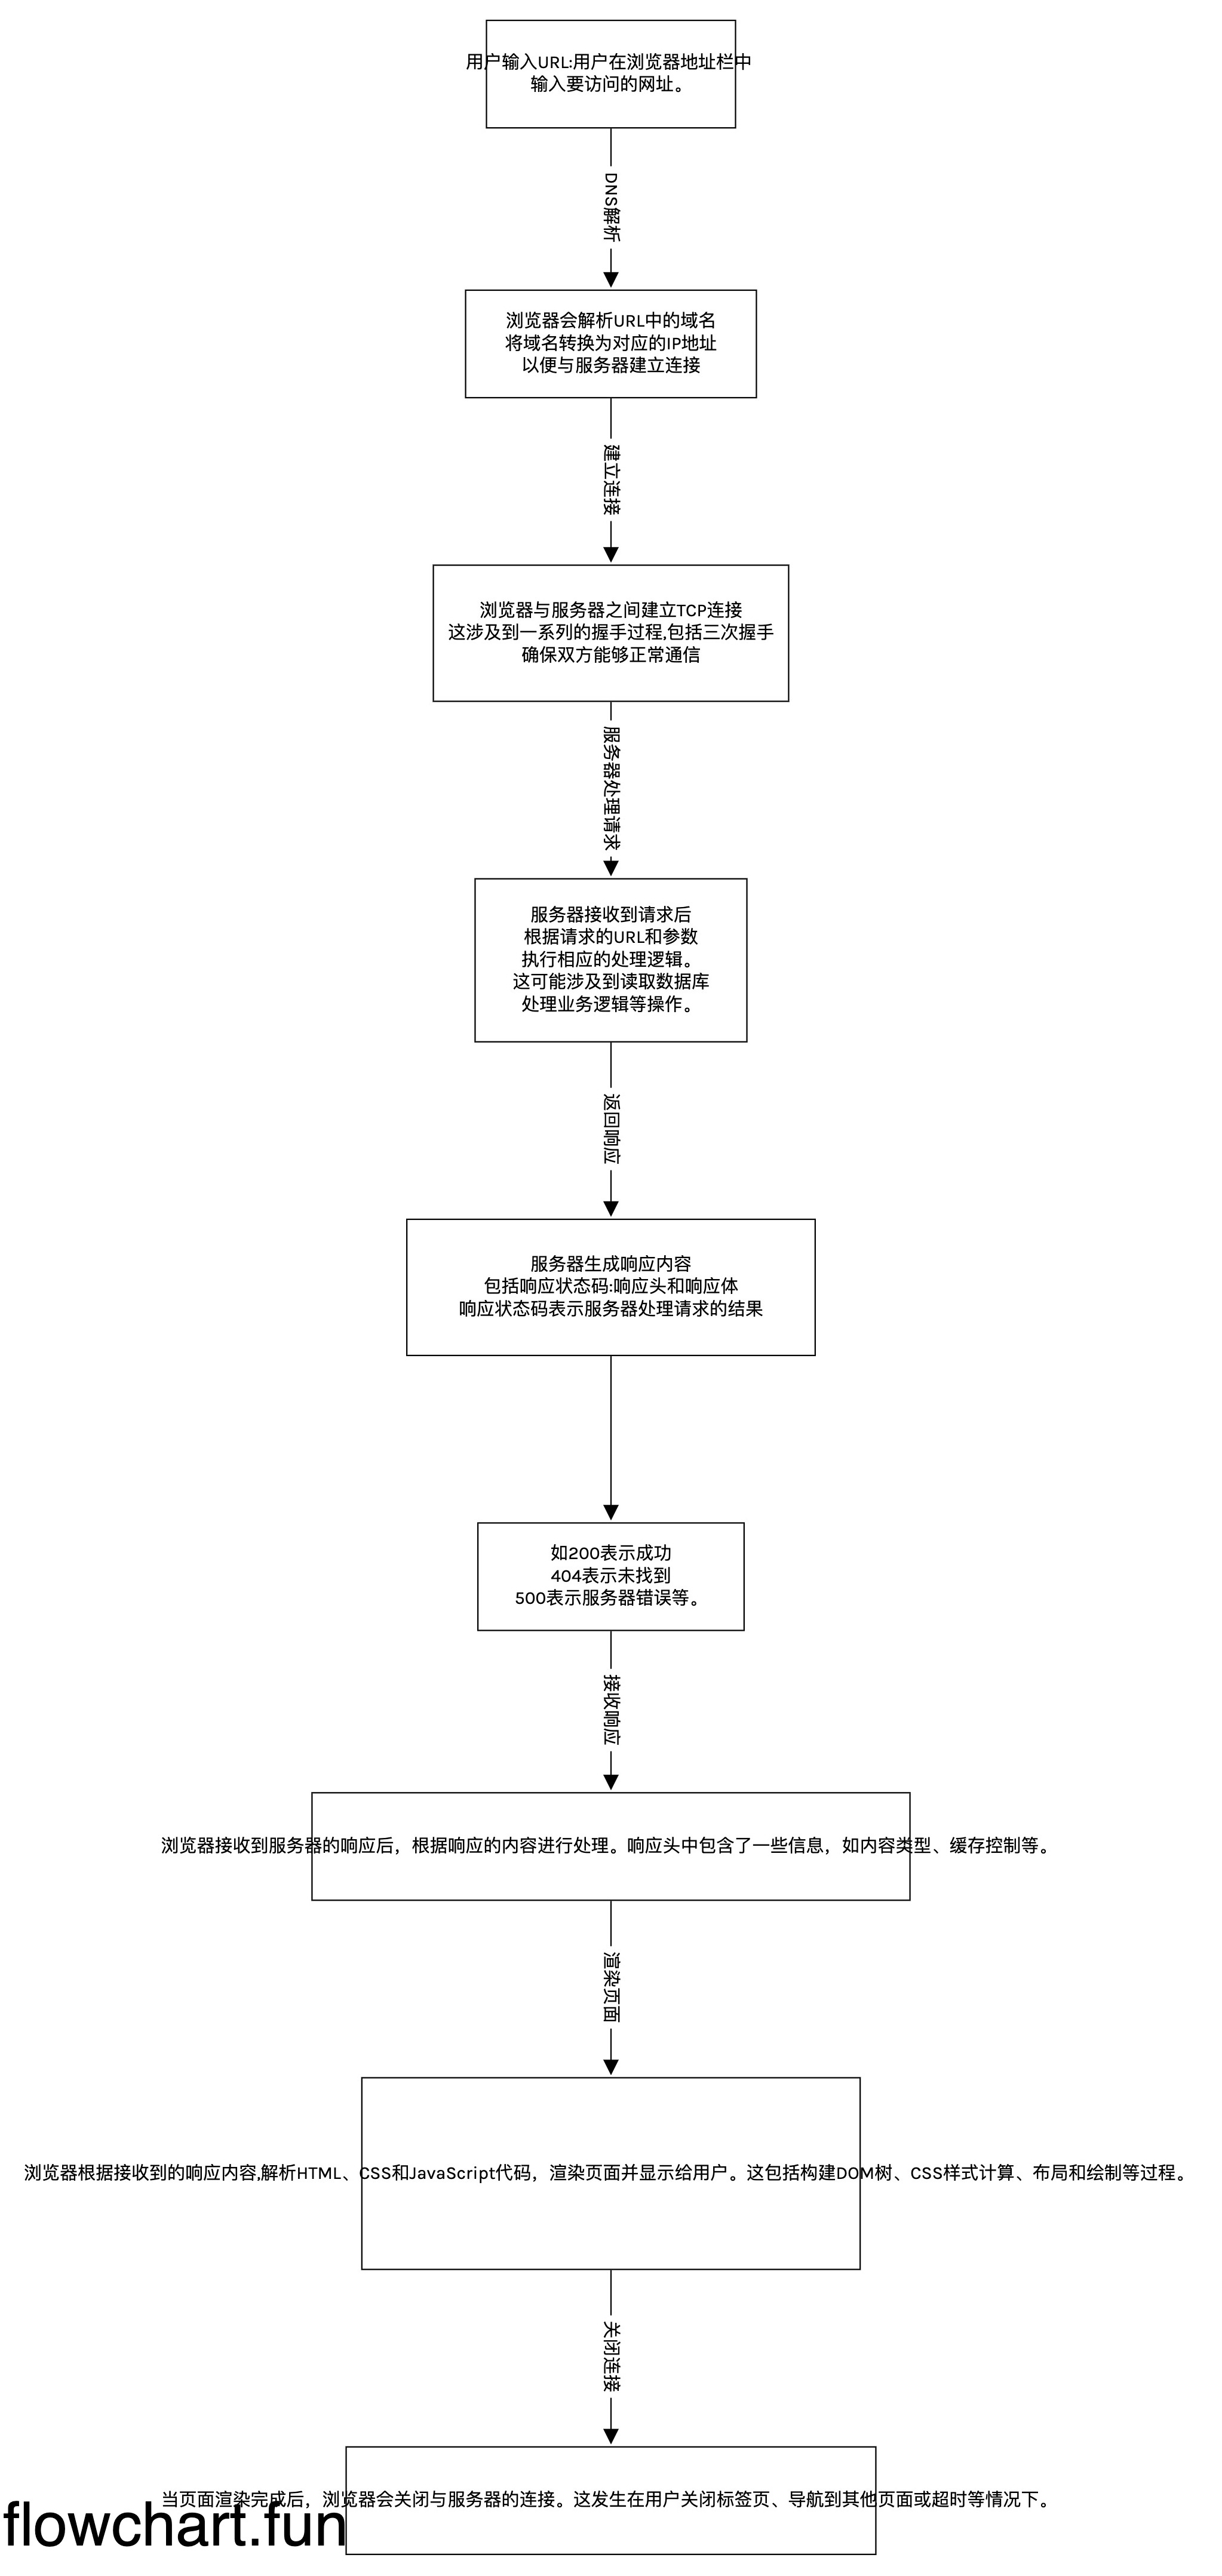

从需求目标出发，共可分为三个部分：

- 评论数据获取
    - 爬虫方式
    - api接口方式
- 评论内容统计分析
    - 统计值
    - 词频->词云
- 评论内容智能分析
    - 情感分析

# 第一步：数据获取

- 网页爬虫:八爪鱼采集方式属于这类型。
- API接口:对于

但是对于B站这个数据，通过一些初期的调研：我们找到了B站官方提供以及他人挖掘的API接口，直接调用API接口，就不需要分析具体网页结构啦。


访问以下链接可以查看：
https://github.com/SocialSisterYi/bilibili-API-collect/tree/master/docs/comment


这个地方也可以找到一些先辈们贡献的接口。

https://www.bilibili.com/read/cv12357091/

我们这里就是通过调用API接口来获取视频的评论数据。具体操作如下：

In [11]:
#api接口可以通过http请求发送
#requests就是这样一个可以用来发送http请求的python库
import requests

from datetime import datetime

import pandas as pd

In [12]:
# 提取BV号
def get_bv(link):
    bv = link.split('/')[-2]
    return bv

# 提取avid
def get_aid(headers, bv):
    # 请求URL:开放api
    # 参考：https://www.bilibili.com/read/cv12357091/ 里面有提及
    url = f'https://api.bilibili.com/x/web-interface/view?bvid={bv}'
    # 发送GET请求
    response = requests.get(url, headers=headers)
    data = response.json()
    # 提取AV号
    aid = data['data']['aid']
    return aid

# 请求评论信息
def get_comment(headers, aid, page, max_retries=3):
    # 请求URL
    # 可以参考：https://github.com/SocialSisterYi/bilibili-API-collect/blob/master/docs/comment/list.md 的接口说明
    url = f'https://api.bilibili.com/x/v2/reply?jsonp=jsonp&pn={page}&type=1&oid={aid}&sort=2'
    # 发送GET请求
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # 检查请求是否成功

    data = response.json()
    return data

In [13]:
# 请求头，添加自己的User-Agent
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.63 Safari/537.36',
}

# 视频链接
video_link = "https://www.bilibili.com/video/BV1WE411y7Uk/?buvid=XYFC69AF7E9A18A64C781F8ED636ACE0DA785&is_story_h5=false&mid=1YqSDB%2F60C7JPhSeFbPVbw%3D%3D&p=1&plat_id=114&share_from=ugc&share_medium=android&share_plat=android&share_source=COPY&share_tag=s_i&timestamp=1687390263&unique_k=MIBEY5r&up_id=78201&vd_source=019be7d6c81625a6a384d0a451f8f66f"

bv = get_bv(video_link)
aid = get_aid(headers, bv)

In [16]:
page = 1
comment_list = []
count = 1
while True:
    data = get_comment(headers, aid, page)

    # 检查是否还有评论
    if 'data' not in data or not data['data']['replies']:
        break

    # 提取评论
    comments = data['data']['replies']
    # 打印评论
    for comment in comments:
        rpid = comment["rpid"]
        mid = comment["member"]["mid"]
        user = comment['member']
        level = user['level_info']['current_level']
        nickname = user['uname']
        avatar = user['avatar']
        comment_time = datetime.fromtimestamp(comment['ctime']).strftime('%Y-%m-%d %H:%M:%S')

        content = comment['content']['message']
        comment_list.append([count, rpid, mid, bv, aid, nickname, level, avatar, comment_time, content])
        count += 1
    print("累计爬取评论数：", count)
    # 增加页数，继续下一页
    page += 1

累计爬取评论数： 20
累计爬取评论数： 40
累计爬取评论数： 60
累计爬取评论数： 80
累计爬取评论数： 100
累计爬取评论数： 120
累计爬取评论数： 139
累计爬取评论数： 159
累计爬取评论数： 179
累计爬取评论数： 199
累计爬取评论数： 219
累计爬取评论数： 239
累计爬取评论数： 258
累计爬取评论数： 278
累计爬取评论数： 298
累计爬取评论数： 318
累计爬取评论数： 338
累计爬取评论数： 358
累计爬取评论数： 378
累计爬取评论数： 398
累计爬取评论数： 418
累计爬取评论数： 438
累计爬取评论数： 458
累计爬取评论数： 478
累计爬取评论数： 498
累计爬取评论数： 518
累计爬取评论数： 538
累计爬取评论数： 558
累计爬取评论数： 578
累计爬取评论数： 598
累计爬取评论数： 618
累计爬取评论数： 638
累计爬取评论数： 658
累计爬取评论数： 678
累计爬取评论数： 684


In [17]:
columns = ["id", "rpid", "mid", "bv", "aid", "level", "nickname", "avatar", "comment_time", "content"]
df = pd.DataFrame(comment_list, columns=columns)

In [18]:
df.to_csv('comments.csv', index=False)

In [19]:
#一些简单的数据统计
df.describe()

,id,rpid,aid,nickname
count,683.000000,6.830000e+02,683.0,683.000000
mean,342.000000,6.387213e+09,73190712.0,5.366032
std,197.309402,2.225835e+10,0.0,0.993005
min,1.000000,2.055745e+09,73190712.0,0.000000
25%,171.500000,2.056529e+09,73190712.0,5.000000
50%,342.000000,2.060572e+09,73190712.0,6.000000
75%,512.500000,2.094617e+09,73190712.0,6.000000
max,683.000000,1.589445e+11,73190712.0,6.000000


In [25]:
#比如我们这里重点关注的评论内容
#那可以简单分析下例如以下几个指标：

#评论的数量
comment_count = df["content"].count()
print("总评论数：", comment_count)

#评论的长度
df["content_len"] = df["content"].apply(lambda x: len(x))
print("评论长度的统计数据：\n", df["content_len"].describe())

#评论的去重总用户数,mid是用户id
# 计算某一列的去重数
unique_count = df['mid'].nunique()
print("评论的去重总用户数:", unique_count)

#可以看到总评论数是683, 去重用户数是644,那也许我们想知道这些发了多条评论的用户是哪些
# 统计某一列中值的出现次数
value_counts = df['mid'].value_counts()

# 筛选出重复出现多次的用户id
duplicated_values = value_counts[value_counts > 1]

# 按照出现次数由大到小排序
duplicated_values = duplicated_values.sort_values(ascending=False)

# 打印重复出现多次的值和对应的出现次数
print("评论多条的用户id: \n", duplicated_values)


总评论数： 683
评论长度的统计数据：
 count    683.000000
mean      19.142020
std       49.266931
min        1.000000
25%        7.000000
50%       12.000000
75%       19.000000
max      940.000000
Name: content_len, dtype: float64
评论的去重总用户数: 644
评论多条的用户id: 
 441571506     5
15328657      3
49925054      3
19768294      3
24408146      3
6574509       3
22357670      2
25734629      2
78201         2
3836066       2
224669713     2
334690630     2
253138180     2
30081499      2
72950838      2
1949057439    2
373156236     2
33357504      2
6614614       2
265925365     2
106851356     2
20999325      2
28840720      2
2062125       2
423376602     2
3247748       2
11723917      2
290492032     2
75164590      2
439017373     2
23249541      2
Name: mid, dtype: int64


上面的代码主要是给了些进行简单统计分析的示例。

你可以根据自己的需求来做其他更多的分析和处理。当然这需要一步一步来熟悉pandas这个库的api方法。


## 评论内容统计分析

我们使用jieba分词库来对数据进行分词，并制作词云

In [34]:
import jieba

comm_list = df["content"].tolist()
comment_str = ' '.join(comm_list)
l = len(comm_list)
word_counts = {}
for i in range(l):
    # 分词
    seg_list = jieba.cut(comm_list[i])
    words = [word for word in seg_list if len(word) >= 2]  # 只保留长度大于等于2的词语
    # 统计词频
    for word in words:
        word_counts[word] = word_counts.get(word, 0) + 1

print(word_counts)

{'好开心': 2, '几位': 1, '广东': 66, '朋友': 2, '北方': 1, '一起': 10, '唱响': 1, '这首': 1, '大湾': 29, '南风': 4, '粤语版': 9, '激动': 1, '无以': 1, '言表': 1, '荔枝': 15, '粤剧': 3, '部分': 6, '江门': 38, '澳门': 8, '希望': 16, '大家': 14, '喜欢': 41, '香港': 33, '重新': 1, '起来': 9, '粤港澳': 12, '繁荣': 2, '缺一不可': 1, '爱心': 14, '首先': 1, '感谢': 2, '团团': 7, '授权': 1, '翻唱': 2, '太有': 2, '意义': 2, '作为': 7, '一定': 5, '自己': 7, '方式': 1, '支持': 14, '一下': 8, '各位': 6, '火箭': 1, '一样': 1, '速度': 1, '填坑': 1, '特别': 6, '里子': 3, '后期': 1, '伴唱': 1, '辛苦': 2, '阿行': 1, '老师': 5, '真的': 20, '很棒': 4, '兴趣': 1, '小伙伴': 4, '欢迎': 2, '廣州': 1, '东莞': 13, '打卡': 51, '珠海': 15, '有没有': 7, '洛天': 3, '前排': 1, '表白': 7, '岚聪行': 1, '琉欣': 1, '策划者': 1, '南越': 1, '千年': 1, '兴怀': 1, '一旦': 1, '歌钟': 1, '旧俗': 1, '烟月': 1, '有层': 1, '北望': 1, '何在': 1, '流水': 1, '不回': 1, '窗风杂': 1, '沾槛': 1, '经梅': 1, '壮气': 1, '空名': 1, '可哀': 1, '不堪': 1, '登览处': 1, '花落': 1, '花开': 1, '广州': 54, '--': 2, '一座': 5, '美味': 2, '食城': 1, '俗话说得好': 1, '食在': 2, '街头': 1, '各种各样': 1, '美食': 1, '小吃': 1, '随处可见': 1, '仔粥': 1, '及第': 1, '生滚': 1, '

In [35]:
!pip install pyecharts
from pyecharts import options as opts
from pyecharts.charts import WordCloud


# 转换为词云数据格式
wordcloud_data = []
for word, count in word_counts.items():
    wordcloud_data.append((word, count))

# 创建 WordCloud 对象
wordcloud = (
    WordCloud()
    .add("", wordcloud_data, word_size_range=[20, 100])
    .set_global_opts(title_opts=opts.TitleOpts(title="中文词云图"))
)

# 渲染生成词云图
wordcloud.render(bv+"wc.html")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 10.8 MB/s eta 0:00:00


'/content/BV1WE411y7Ukwc.html'

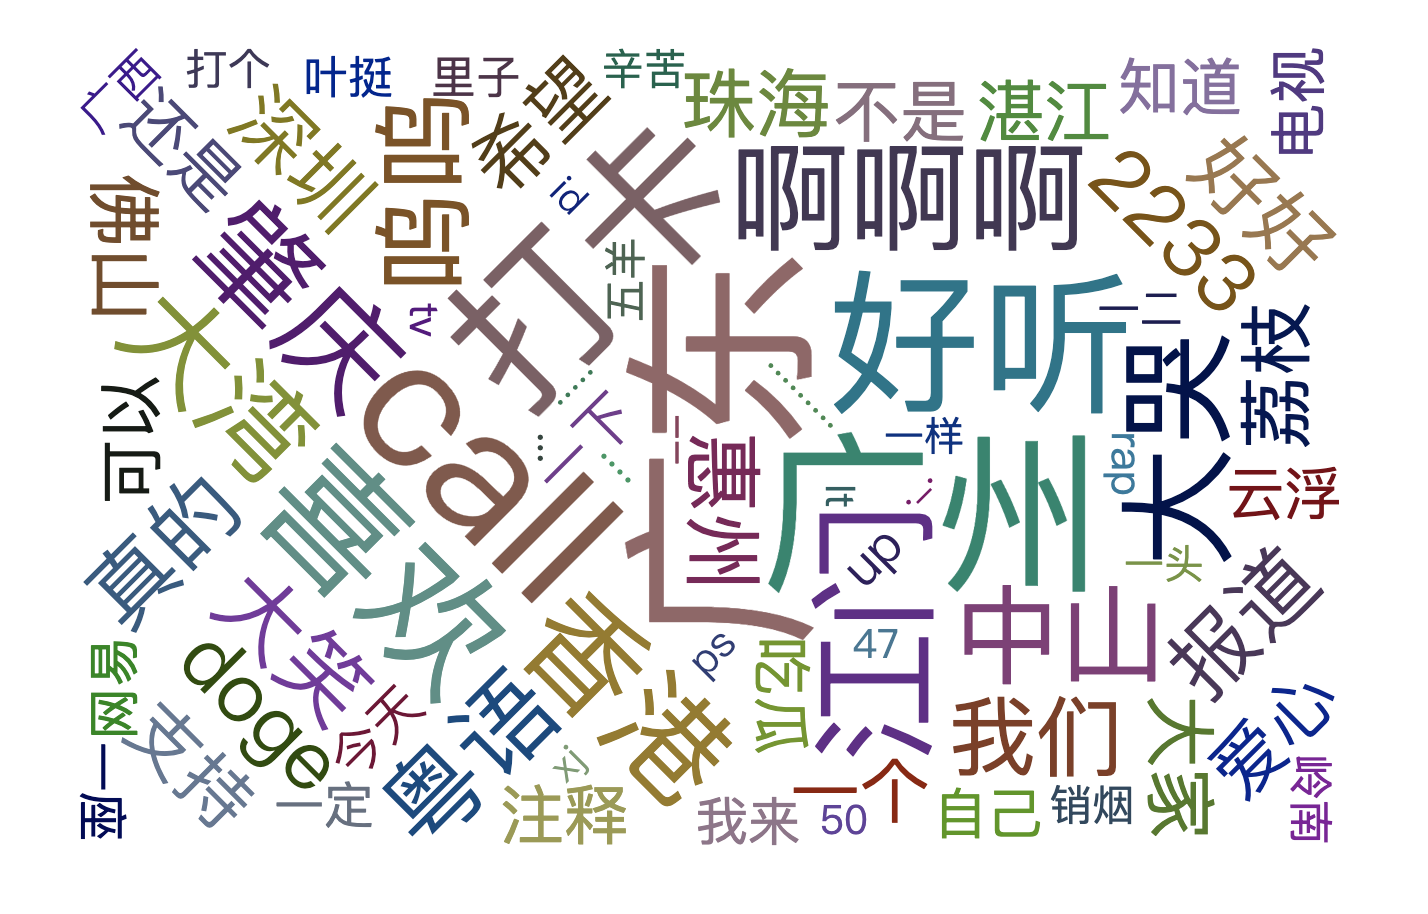

## 评论内容智能分析

最后我们针对每一条评论来分析情感倾向。

这里简单演示，我们选择比较简单的库来调用from snownlp import SnowNLP

In [41]:
!pip install snownlp
from snownlp import SnowNLP
def get_sent(text):
    # 使用SnowNLP进行情感分析
    s = SnowNLP(text)
    sentiment = s.sentiments
    sentiment_label = 0
    # 判断情感倾向
    if sentiment > 0.5:
        sentiment_label = "正"
    elif sentiment == 0.5:
        sentiment_label = "中"
    else:
        sentiment_label = "负"
    return text, sentiment_label, sentiment


# 情感分析
sentiments = [get_sent(comment) for comment in comm_list]

df["senti_socre"] = [score for _, _, score in sentiments]
df["senti_label"] = [label for _, label, _ in sentiments]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
# 保存到另一个数据表中
df.to_csv('comments_senti.csv', encoding='utf-8', index=False)

In [43]:
#可以继续分析下正负的比例
# 使用 value_counts() 方法计算每个值的频率
value_counts = df['senti_label'].value_counts()

# 计算占比
percentage = value_counts / len(df) * 100

# 打印占比
print(percentage)

正    65.153734
负    32.210835
中     2.635432
Name: senti_label, dtype: float64
